## Classification of MNIST dataset with tensor networks

In [1]:
# import packages here
# --------------------------------------
import matplotlib.pyplot as plt

import qtealeaves as qtl
from qtealeaves.convergence_parameters.conv_params import TNConvergenceParameters
from qtealeaves.emulator.mps_simulator import MPS
from qtealeaves.emulator import StateVector

from tensorflow.keras.datasets import mnist
import numpy as np


2024-05-23 11:04:18.666508: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 11:04:18.672775: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-23 11:04:18.813836: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-23 11:04:18.815865: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 11:04:19.562315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

### Load MNIST dataset

In [2]:
# Load dataset here
# --------------------------------------
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28)
(10000, 28, 28)


In [3]:
# Selecting only images with the numbers 3 and 8
train_filter = np.where((y_train == 3 ) | (y_train == 8))
test_filter = np.where((y_test == 3) | (y_test == 8))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

train_idxs_3 = np.where(y_train == 3)
train_idxs_8 = np.where(y_train == 8)
test_idxs_3 = np.where(y_test == 3)
test_idxs_8 = np.where(y_test == 8)

y_train[train_idxs_3] = 0
y_train[train_idxs_8] = 1
y_test[test_idxs_3] = 0
y_test[test_idxs_8] = 1

# Reduce amount of images
nr_images = 500

x_train, y_train, x_test, y_test = x_train[:nr_images, :, :], y_train[:nr_images], x_test[:nr_images, :, :], y_test[:nr_images]

x_train = x_train / 255
x_test = x_test / 255

0


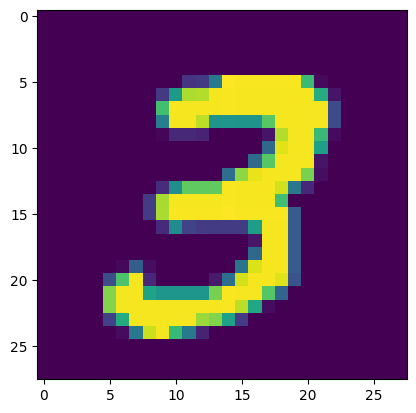

In [4]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0, :, :])
print(y_train[0])

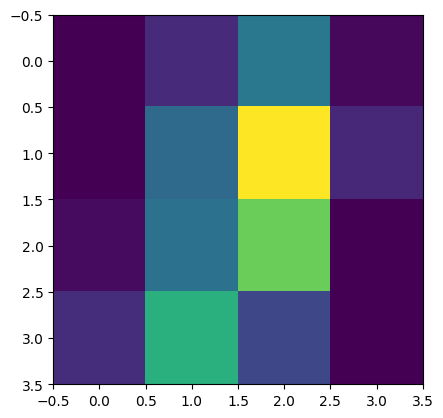

In [5]:
import skimage.measure

x_train = skimage.measure.block_reduce(x_train, (1,7, 7), np.mean)
x_test = skimage.measure.block_reduce(x_test, (1,7,7), np.mean)

plt.imshow(x_train[0, :, :])




In [6]:
x = np.random.rand(100, 100)

In [7]:
import tensorflow as tf

test = (x_test, y_test)

size=4
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(size,size)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

model.fit(x_train, y_train, epochs=100,validation_data=test,
)

Epoch 1/100


2024-05-23 11:04:21.504900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 11:04:21.514625: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


16/16 [==============================] - 0s 10ms/step - loss: 0.6765 - binary_accuracy: 0.5240 - val_loss: 0.6711 - val_binary_accuracy: 0.5140
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6456 - binary_accuracy: 0.5240 - val_loss: 0.6468 - val_binary_accuracy: 0.5140
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6139 - binary_accuracy: 0.5380 - val_loss: 0.6201 - val_binary_accuracy: 0.5280
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5801 - binary_accuracy: 0.5820 - val_loss: 0.5932 - val_binary_accuracy: 0.5420
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5441 - binary_accuracy: 0.6440 - val_loss: 0.5634 - val_binary_accuracy: 0.5680
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5076 - binary_accuracy: 0.6960 - val_loss: 0.5326 - val_binary_accuracy: 0.6200
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4701 -

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 128)               2176      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2305 (9.00 KB)
Trainable params: 2305 (9.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Decompose MPO

In [9]:
up_legs=[4,4,4,2]
down_legs=[2,2,2,2]
bonds=[8,32,4]

def MPO_from_mat(mat,up_legs,down_legs,bonds,bd_cut=0,verbose=False):

    temp=mat
    if verbose:print(f"Initial Matrix: {np.shape(temp)}")

    #unsqueeze
    x,y=np.shape(temp)
    temp=np.reshape(temp,(1,x,y,1))
    if verbose:print(f"Unsqueezed: {np.shape(temp)}")
    
    sites=len(up_legs)
    if verbose:print(f"Creating MPO with: {sites} sites\n")

    operators=[]
    S_original=[]
    S_cut=[]
    for i in range(sites):

        if verbose:print(f"Building tensor {i}")

        #LEFTMOST TENSOR
        if i==0:
            
            #split legs 
            temp=np.reshape(temp,(1,down_legs[i],np.prod(down_legs[i+1:]),up_legs[i],np.prod(up_legs[i+1:]),1))
            if verbose:print(f"Splitted legs: {np.shape(temp)}")

            #transpose 
            temp=np.transpose(temp,(0,1,3,2,4,5))
            if verbose:print(f"Transpose: {np.shape(temp)}")

            #join legs 
            left,x,y,z,t,right=np.shape(temp)
            temp=np.reshape(temp,(left*x*y,z*t*right))
            if verbose:print(f"Joined:{np.shape(temp)}")

            #perform SVD
            U,S,V = np.linalg.svd(temp,full_matrices=False)
            S_original.append(S)
            if verbose:print(f"Operator before cut :{np.shape(U)}")

            #perform cut
            if bd_cut!=0:
                eff_cut=min(int(np.shape(U)[-1]),bd_cut)
                U=U[:,:eff_cut];S=S[:eff_cut];V=V[:eff_cut,:];
            if verbose:print(f"Operator after cut :{np.shape(U)}")
            S_cut.append(S)

            #build operator 
            right_dim=np.shape(U)[-1]
            op=np.reshape(U,(1,down_legs[i],up_legs[i],right_dim))
            operators.append(op)
            if verbose:print(f"Stored operator:{np.shape(op)}")

            #return temp 
            temp=np.tensordot(np.diag(S),V,axes=([1,0]))
            if verbose:print(f"Next matrix:{np.shape(temp)}\n")

        #RIGHTMOST
        elif i==sites-1:

            #reshape operatr 
            op=np.reshape(temp,(bonds[-1],down_legs[i],up_legs[i],1))
            if verbose:print(f"Final tensor:{np.shape(op)}")
            operators.append(op)
        
        #CENTRAL TENSOR
        else:

            left,right=np.shape(temp)
            #split legs 
            temp=np.reshape(temp,(left,down_legs[i],np.prod(down_legs[i+1:]),up_legs[i],np.prod(up_legs[i+1:])))
            if verbose:print(f"Splitted legs: {np.shape(temp)}")

            #transpose 
            temp=np.transpose(temp,(0,1,3,2,4))
            if verbose:print(f"Transpose: {np.shape(temp)}")

            #join legs 
            left,x,y,z,t=np.shape(temp)
            temp=np.reshape(temp,(left*x*y,z*t))
            if verbose:print(f"Joined:{np.shape(temp)}")

            #perform SVD
            U,S,V = np.linalg.svd(temp,full_matrices=False)
            if verbose:print(f"Operator before cut :{np.shape(U)}")

            #perform cut
            if bd_cut!=0:
                eff_cut=min(np.shape(U)[-1],bd_cut)
                U=U[:,:eff_cut];S=S[:eff_cut];V=V[:eff_cut,:];
            if verbose:print(f"Operator after cut :{np.shape(U)}")

            #build operator 
            right_dim=np.shape(U)[-1]
            op=np.reshape(U,(left,down_legs[i],up_legs[i],right_dim))
            operators.append(op)

            #return temp 
            temp=np.tensordot(np.diag(S),V,axes=([1,0]))
            if verbose:print(f"Next matrix:{np.shape(temp)}\n")

    return [operators,S_original,S_cut]
            

MPO,S,S_cut=MPO_from_mat(model.weights[0],up_legs,down_legs,bonds,bd_cut=16)

In [10]:
## Count number of parameters in MPO 

def count_params(MPO):

    #select tensr
    total_params=0
    for tensor in MPO:

        #tensor params 
        x,y,z,t=np.shape(tensor)
        tensor_params=x*y*z*t
        total_params+=tensor_params


    return total_params
           

## Recompose weights matrix

In [11]:
def contract_MPO(MPO):
    temp=np.ones((1,1,1,1))
    for i in range(len(MPO)):
    
        #print(np.shape(temp))
        #left operator
        x,y,z,t=np.shape(temp)
    
        #store RIGHT operator
        op=MPO[i]; x1,y1,z1,t1=np.shape(op);
    
        #contract
        mat=np.tensordot(temp,op,axes=([3,0]))
        
        #print(np.shape(mat))
    
        #transpose
        mat=np.transpose(mat,(0,1,3,2,4,5))
        #print(np.shape(mat))
        left,top1,top2,bottom1,bottom2,right=np.shape(mat)
    
        #get shapes 
        mat=np.reshape(mat,(left,top1*top2,bottom1*bottom2,right))
        #print(np.shape(mat))
    
        #update 
        temp=mat
        #print("!",np.shape(temp))
    
    
    x,y,z,t=np.shape(temp)
    
    final=np.reshape(temp,(x*y,z*t))
    #print(np.shape(final))

    return final


final=contract_MPO(MPO)

In [12]:
#bond_dims=[60,40,30,20,17,15,13,12,11,10,9,8,7,6,5,4]
bond_dims=np.arange(60,5,-1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(size,size)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

#train the model
model.fit(x_train, y_train, epochs=100,validation_data=test)

# Evaluate the model on the test data using `evaluate`
print("Initial: Evaluate on test data")
original_loss, original_acc = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", original_loss,original_acc)

#get the weights 
weights=model.weights[0]

full_params=np.shape(weights)[0]*np.shape(weights)[1]

test_losses=[];test_accs=[];n_params=[]
for bd in bond_dims:

    #create MPO
    MPO,S,S_cut=MPO_from_mat(weights,up_legs,down_legs,bonds,bd_cut=bd,verbose=False)

    #compute params
    params=count_params(MPO)
    n_params.append(params)
    

    #recontract MPO
    final=contract_MPO(MPO)

    #reload the weights
    bias=model.layers[1].weights[1]
    model.layers[1].set_weights([final,bias])
    
    # Evaluate the model on the test data using `evaluate`
    print(f"Evaluate on test data wiht bd {bd}")
    results = model.evaluate(x_test, y_test, batch_size=128)
    print("test loss, test acc:", results)

    #store
    test_losses.append(results[0])
    test_accs.append(results[1])

Epoch 1/100


16/16 [==============================] - 0s 8ms/step - loss: 0.6944 - binary_accuracy: 0.5240 - val_loss: 0.6848 - val_binary_accuracy: 0.5140
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6599 - binary_accuracy: 0.5240 - val_loss: 0.6579 - val_binary_accuracy: 0.5140
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6269 - binary_accuracy: 0.5240 - val_loss: 0.6305 - val_binary_accuracy: 0.5140
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.5943 - binary_accuracy: 0.5280 - val_loss: 0.6057 - val_binary_accuracy: 0.5160
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5604 - binary_accuracy: 0.5740 - val_loss: 0.5777 - val_binary_accuracy: 0.5460
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5269 - binary_accuracy: 0.6520 - val_loss: 0.5488 - val_binary_accuracy: 0.5700
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4909 - 

## Accuracy and Loss Plots

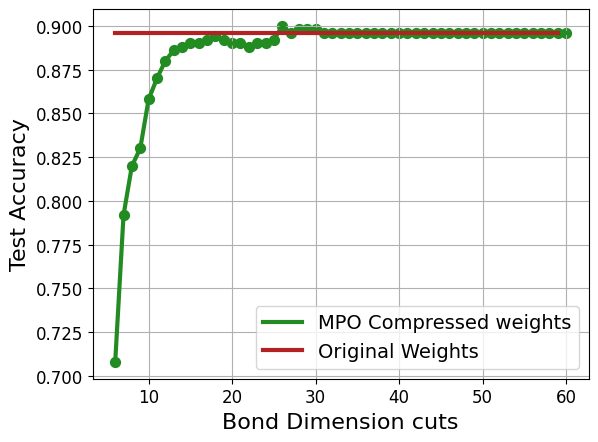

In [30]:
from matplotlib import pyplot as plt

plt.figure(1)
#plt.title(f"NN Accuracy after MPO compression")
x = np.arange(min(bond_dims),max(bond_dims))

plt.plot(bond_dims,test_accs, color="forestgreen",label="MPO Compressed weights", lw = 3)
plt.scatter(bond_dims,test_accs, color="forestgreen", s = 50)
plt.plot(x,np.repeat(original_acc,len(x)),color="firebrick",label="Original Weights", lw = 3)
plt.grid()
plt.legend(loc="lower right", fontsize = 14)
plt.ylabel("Test Accuracy", fontsize = 16)
plt.xlabel("Bond Dimension cuts", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("figs/accuracy_vs_bd.png")
plt.show()

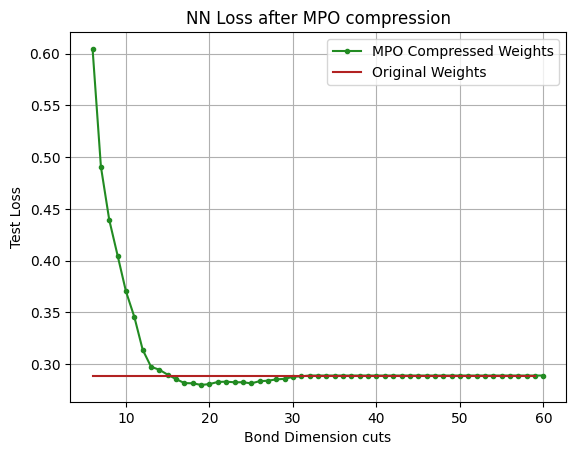

In [26]:
plt.figure(2)
#plt.title(f"NN Loss after MPO compression")
x=np.arange(min(bond_dims),max(bond_dims))
plt.plot(bond_dims,test_losses,color="forestgreen",label="MPO Compressed Weights")
plt.plot(x,np.repeat(original_loss,len(x)),color="firebrick",label="Original Weights")
plt.grid()
plt.legend(loc="upper right")
plt.ylabel("Test Loss")
plt.xlabel("Bond Dimension cuts")
plt.savefig("./loss_vs_bd.png")
plt.show()

## Number of parameters


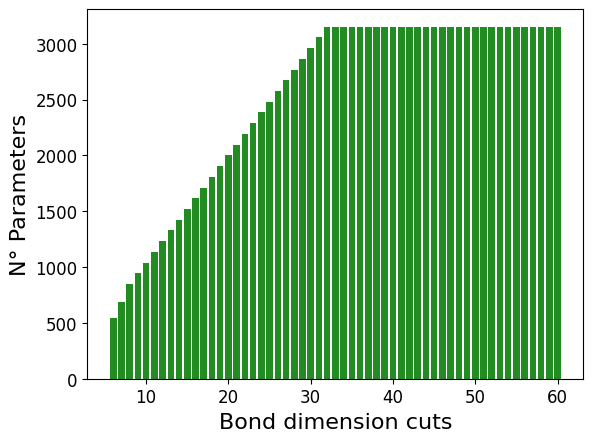

In [31]:
fig, ax1 = plt.subplots()
ax1.bar(bond_dims,np.array(n_params),color="forestgreen")
ax1.set_xlabel("Bond dimension cuts", fontsize = 16)
ax1.set_ylabel("N° Parameters", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig("./parameters.png")

